# GANs: Monet Painting Dataset

In this analysis a generative adversarial network (GAN) that can produce images in the style of Claude Monet will be produced. The goal is to train a generator to create these Monet-like images and a discriminator to tell the difference between real Monet paintings and the generated ones. The goal is to create 7,000 to 10,000 images that closely resemble Monet's style, making it difficult for classifiers to distinguish them from the originals.

In [162]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, ReLU, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

## EDA

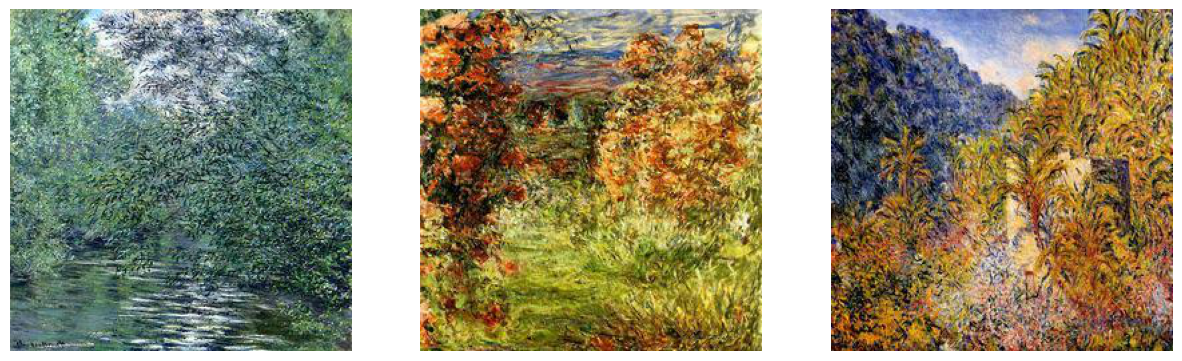

In [164]:
# Load the images from the content directory
image_paths = ['style/monet_jpg/4f7e01f097.jpg', 
               'style/monet_jpg/ad0101d010.jpg', 
               'style/monet_jpg/a7d53885e8.jpg']  
images = [Image.open(path) for path in image_paths]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')  

plt.show()

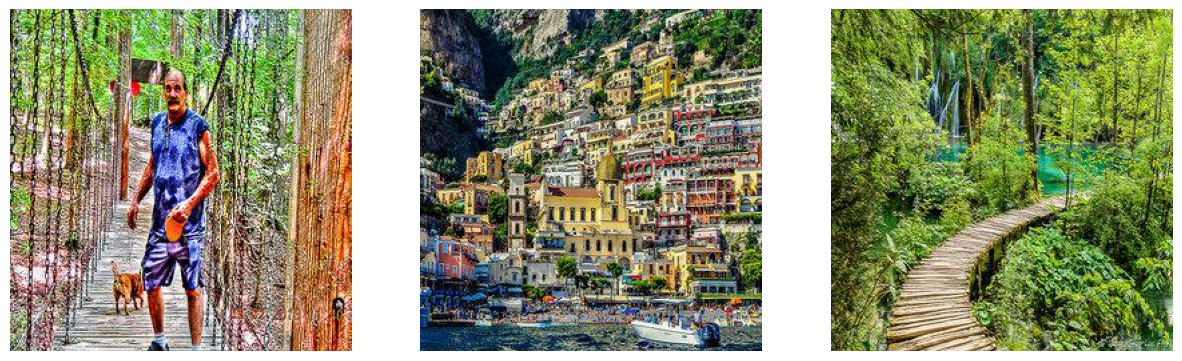

In [163]:
# Load the images from the content directory
image_paths = ['content/photo_jpg/f01164b232.jpg', 
               'content/photo_jpg/21c2c68337.jpg', 
               'content/photo_jpg/2339fbceb2.jpg']  
images = [Image.open(path) for path in image_paths]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')  

plt.show()

## Architecture

This function sets up a generator model that compresses input images into a lower-dimensional feature space using an encoder made up of convolutional layers with LeakyReLU activations. It then rebuilds the image to its original size through a decoder that uses transposed convolutional layers and ReLU activations, finishing with a tanh activation for the final output. The model effectively transforms the input image while keeping key features intact, making it a good fit for tasks like style transfer in GANs.

In [124]:
def build_simple_generator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = ReLU()(x)

    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh')(x)

    model = Model(inputs, x)
    return model

This function is a discriminator model that takes an input image and runs it through several convolutional layers with LeakyReLU activations, which gradually extract features while shrinking the image size. The output is then flattened and fed into a dense layer with a sigmoid activation, producing a single value between 0 and 1 that indicates whether the input image is real or generated. This model is meant to distinguish between real and fake images in a GAN setup.

In [125]:
def build_simple_discriminator(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, x)
    return model

This setup combines a generator and a non-trainable discriminator into a GAN. It takes an input image, generates a new one through the generator, and then checks its authenticity with the discriminator. The model outputs both the generated image and its validity, helping train the generator to create more convincing images.

In [126]:
def build_gan(generator, discriminator, input_shape=(256, 256, 3)):
    discriminator.trainable = False
    
    input_image = Input(shape=input_shape)
    generated_image = generator(input_image)
    validity = discriminator(generated_image)
    
    combined_model = Model(input_image, [validity, generated_image])
    return combined_model

In [161]:
# function to load in images
def load_image_data(style_path, content_path, img_size=(256, 256)):
    datagen = ImageDataGenerator(rescale=1./255)

    style_data = datagen.flow_from_directory(style_path, target_size=img_size, batch_size=1, class_mode=None)
    content_data = datagen.flow_from_directory(content_path, target_size=img_size, batch_size=1, class_mode=None)
    
    return style_data, content_data

This following function compiles and trains a GAN by first setting up the discriminator with a binary cross-entropy loss and Adam optimizer, then combines it with the generator to create the GAN model. During training, it alternates between training the discriminator on real and generated images and training the generator to create images that can trick the discriminator. The process runs for a set number of epochs, with the function printing out the discriminator's loss and accuracy, as well as the generator's loss, after each round.

In [133]:
# Function to compile and train the GAN
def compile_and_train_simple(generator, discriminator, style_data, content_data, epochs=50, batch_size=1):
    # Compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])

    # Combine models
    discriminator.trainable = False 
    combined_input = Input(shape=(256, 256, 3))
    generated_image = generator(combined_input)
    validity = discriminator(generated_image)

    combined_model = Model(combined_input, validity)
    combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

    # Labels for real and fake images
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for i in range(min(len(style_data), len(content_data))):
            # Get the real content and style images
            content_img = content_data.next()
            style_img = style_data.next()

            # Generate fake images
            fake_img = generator.predict(content_img)

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(style_img, real_label)
            d_loss_fake = discriminator.train_on_batch(fake_img, fake_label)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            g_loss = combined_model.train_on_batch(content_img, real_label)
           
            print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {d_loss[1] * 100:.2f}%] [G loss: {g_loss:.4f}]")

The following code sets up and trains a GAN to apply a specific style to images. It starts by loading style and content images, then builds a generator to create styled images and a discriminator to evaluate them. These models are combined into a GAN, which is then compiled and trained with the loaded data over three epochs to generate images that blend the content from one set with the style of another.

In [134]:
style_path = 'style'
content_path = 'content'

style_data, content_data = load_image_data(style_path, content_path)

generator = build_generator()
discriminator = build_discriminator()

combined = build_gan(generator, discriminator)

compile_and_train(generator, discriminator, combined, style_data, content_data, epochs=3)

Found 300 images belonging to 1 classes.
Found 7038 images belonging to 1 classes.
Epoch 1/3 [D loss: 0.5077314669189814, acc.: 50.0%] [G loss: 1.8881340026855469]
Epoch 1/3 [D loss: 0.5065445473510053, acc.: 50.0%] [G loss: 1.5659759044647217]
Epoch 1/3 [D loss: 0.5070326601166926, acc.: 50.0%] [G loss: 1.387876033782959]
Epoch 1/3 [D loss: 0.5052304794684233, acc.: 50.0%] [G loss: 1.2344247102737427]
Epoch 1/3 [D loss: 0.506621878821079, acc.: 50.0%] [G loss: 1.1335190534591675]
Epoch 1/3 [D loss: 0.508341176940803, acc.: 50.0%] [G loss: 1.1057634353637695]
Epoch 1/3 [D loss: 0.5068110055890429, acc.: 50.0%] [G loss: 1.0643230676651]
Epoch 1/3 [D loss: 0.5104376858130308, acc.: 50.0%] [G loss: 1.0578246116638184]
Epoch 1/3 [D loss: 0.5069500409008469, acc.: 50.0%] [G loss: 0.9900810122489929]
Epoch 1/3 [D loss: 0.5065716669855647, acc.: 50.0%] [G loss: 0.9892667531967163]
Epoch 1/3 [D loss: 0.5043804742854263, acc.: 50.0%] [G loss: 1.0027498006820679]
Epoch 1/3 [D loss: 0.50731187086

Epoch 1/3 [D loss: 0.5368103198707104, acc.: 50.0%] [G loss: 0.8173040151596069]
Epoch 1/3 [D loss: 0.5316304881125689, acc.: 50.0%] [G loss: 0.8662889003753662]
Epoch 1/3 [D loss: 0.5366270393133163, acc.: 50.0%] [G loss: 0.8578455448150635]
Epoch 1/3 [D loss: 0.5350129716098309, acc.: 50.0%] [G loss: 0.8249452710151672]
Epoch 1/3 [D loss: 0.536498324945569, acc.: 50.0%] [G loss: 0.8369404077529907]
Epoch 1/3 [D loss: 0.5358250290155411, acc.: 50.0%] [G loss: 0.8493877649307251]
Epoch 1/3 [D loss: 0.5351212006062269, acc.: 50.0%] [G loss: 0.8239050507545471]
Epoch 1/3 [D loss: 0.5349163450300694, acc.: 50.0%] [G loss: 0.8497364521026611]
Epoch 1/3 [D loss: 0.5362924169749022, acc.: 50.0%] [G loss: 0.831498384475708]
Epoch 1/3 [D loss: 0.5380468405783176, acc.: 50.0%] [G loss: 0.8356893062591553]
Epoch 1/3 [D loss: 0.5356674082577229, acc.: 50.0%] [G loss: 0.8629379272460938]
Epoch 1/3 [D loss: 0.537634763866663, acc.: 50.0%] [G loss: 0.8042104244232178]
Epoch 1/3 [D loss: 0.5366364642

Epoch 1/3 [D loss: 0.5588521733880043, acc.: 50.0%] [G loss: 0.8225111365318298]
Epoch 1/3 [D loss: 0.5610818900167942, acc.: 50.0%] [G loss: 0.8239940404891968]
Epoch 1/3 [D loss: 0.5650597438216209, acc.: 50.0%] [G loss: 0.8171643018722534]
Epoch 1/3 [D loss: 0.564838208258152, acc.: 50.0%] [G loss: 0.802075207233429]
Epoch 1/3 [D loss: 0.5608063489198685, acc.: 50.0%] [G loss: 0.884292483329773]
Epoch 1/3 [D loss: 0.5630487017333508, acc.: 50.0%] [G loss: 0.8412157297134399]
Epoch 1/3 [D loss: 0.5646577179431915, acc.: 50.0%] [G loss: 0.8376598358154297]
Epoch 1/3 [D loss: 0.5653964132070541, acc.: 50.0%] [G loss: 0.8284268379211426]
Epoch 1/3 [D loss: 0.5643355697393417, acc.: 50.0%] [G loss: 0.8078994750976562]
Epoch 1/3 [D loss: 0.5657873377203941, acc.: 50.0%] [G loss: 0.7932076454162598]
Epoch 1/3 [D loss: 0.5668766722083092, acc.: 50.0%] [G loss: 0.8179989457130432]
Epoch 1/3 [D loss: 0.5674005970358849, acc.: 50.0%] [G loss: 0.7980616092681885]
Epoch 1/3 [D loss: 0.5610748901

Epoch 2/3 [D loss: 0.5695446878671646, acc.: 50.0%] [G loss: 0.8495180010795593]
Epoch 2/3 [D loss: 0.5736771374940872, acc.: 50.0%] [G loss: 0.8641418218612671]
Epoch 2/3 [D loss: 0.5774092897772789, acc.: 50.0%] [G loss: 0.8302419185638428]
Epoch 2/3 [D loss: 0.5789893865585327, acc.: 50.0%] [G loss: 0.8206398487091064]
Epoch 2/3 [D loss: 0.5772195979952812, acc.: 50.0%] [G loss: 0.8080546855926514]
Epoch 2/3 [D loss: 0.5734798014163971, acc.: 50.0%] [G loss: 0.7896366119384766]
Epoch 2/3 [D loss: 0.5717338472604752, acc.: 50.0%] [G loss: 0.7969352602958679]
Epoch 2/3 [D loss: 0.5715517848730087, acc.: 50.0%] [G loss: 0.8774504661560059]
Epoch 2/3 [D loss: 0.579524502158165, acc.: 50.0%] [G loss: 0.8160549402236938]
Epoch 2/3 [D loss: 0.5744478106498718, acc.: 50.0%] [G loss: 0.8631006479263306]
Epoch 2/3 [D loss: 0.5775530114769936, acc.: 50.0%] [G loss: 0.8288741111755371]
Epoch 2/3 [D loss: 0.5785691738128662, acc.: 50.0%] [G loss: 0.8145935535430908]
Epoch 2/3 [D loss: 0.57301646

Epoch 2/3 [D loss: 0.5778179466724396, acc.: 50.0%] [G loss: 0.8118770718574524]
Epoch 2/3 [D loss: 0.5776247754693031, acc.: 50.0%] [G loss: 0.7870004177093506]
Epoch 2/3 [D loss: 0.5810647159814835, acc.: 50.0%] [G loss: 0.8167449235916138]
Epoch 2/3 [D loss: 0.5823199898004532, acc.: 50.0%] [G loss: 0.806106448173523]
Epoch 2/3 [D loss: 0.5770052447915077, acc.: 50.0%] [G loss: 0.8635340929031372]
Epoch 2/3 [D loss: 0.5839962959289551, acc.: 50.0%] [G loss: 0.8474876880645752]
Epoch 2/3 [D loss: 0.5827035307884216, acc.: 50.0%] [G loss: 0.8099780082702637]
Epoch 2/3 [D loss: 0.5762969255447388, acc.: 50.0%] [G loss: 0.818793535232544]
Epoch 2/3 [D loss: 0.5812986791133881, acc.: 50.0%] [G loss: 0.7887773513793945]
Epoch 2/3 [D loss: 0.5798842906951904, acc.: 50.0%] [G loss: 0.8178589344024658]
Epoch 2/3 [D loss: 0.5807650834321976, acc.: 50.0%] [G loss: 0.8199039697647095]
Epoch 2/3 [D loss: 0.5822100043296814, acc.: 50.0%] [G loss: 0.8013546466827393]
Epoch 2/3 [D loss: 0.582133091

Epoch 2/3 [D loss: 0.5841947942972183, acc.: 50.0%] [G loss: 0.8252317905426025]
Epoch 2/3 [D loss: 0.5857662186026573, acc.: 50.0%] [G loss: 0.8133248090744019]
Epoch 2/3 [D loss: 0.5828970819711685, acc.: 50.0%] [G loss: 0.7923750281333923]
Epoch 2/3 [D loss: 0.5757079869508743, acc.: 50.0%] [G loss: 0.8250670433044434]
Epoch 2/3 [D loss: 0.5830638110637665, acc.: 50.0%] [G loss: 0.8256480097770691]
Epoch 2/3 [D loss: 0.5856408700346947, acc.: 50.0%] [G loss: 0.8302788734436035]
Epoch 2/3 [D loss: 0.577056460082531, acc.: 50.0%] [G loss: 0.8193220496177673]
Epoch 2/3 [D loss: 0.5821499451994896, acc.: 50.0%] [G loss: 0.8219102621078491]
Epoch 2/3 [D loss: 0.5867381170392036, acc.: 50.0%] [G loss: 0.8302971124649048]
Epoch 2/3 [D loss: 0.5832005739212036, acc.: 50.0%] [G loss: 0.8407084345817566]
Epoch 2/3 [D loss: 0.5823360085487366, acc.: 50.0%] [G loss: 0.8082306385040283]
Epoch 2/3 [D loss: 0.5819490775465965, acc.: 50.0%] [G loss: 0.8242053985595703]
Epoch 2/3 [D loss: 0.58067183

Epoch 3/3 [D loss: 0.5826202034950256, acc.: 50.0%] [G loss: 0.7963743209838867]
Epoch 3/3 [D loss: 0.5788161009550095, acc.: 50.0%] [G loss: 0.8247644305229187]
Epoch 3/3 [D loss: 0.5797359943389893, acc.: 50.0%] [G loss: 0.8199672102928162]
Epoch 3/3 [D loss: 0.584698960185051, acc.: 50.0%] [G loss: 0.7899331450462341]
Epoch 3/3 [D loss: 0.5855658501386642, acc.: 50.0%] [G loss: 0.8332706093788147]
Epoch 3/3 [D loss: 0.5731241405010223, acc.: 50.0%] [G loss: 0.8502733111381531]
Epoch 3/3 [D loss: 0.5790615603327751, acc.: 50.0%] [G loss: 0.8320348262786865]
Epoch 3/3 [D loss: 0.5858517438173294, acc.: 50.0%] [G loss: 0.8222147226333618]
Epoch 3/3 [D loss: 0.5872944220900536, acc.: 50.0%] [G loss: 0.7990961670875549]
Epoch 3/3 [D loss: 0.5826487690210342, acc.: 50.0%] [G loss: 0.8151341676712036]
Epoch 3/3 [D loss: 0.5815518945455551, acc.: 50.0%] [G loss: 0.8053659796714783]
Epoch 3/3 [D loss: 0.5843665301799774, acc.: 50.0%] [G loss: 0.8146556615829468]
Epoch 3/3 [D loss: 0.58572030

Epoch 3/3 [D loss: 0.5876268297433853, acc.: 50.0%] [G loss: 0.8231611251831055]
Epoch 3/3 [D loss: 0.5904619097709656, acc.: 50.0%] [G loss: 0.8110998868942261]
Epoch 3/3 [D loss: 0.5885104089975357, acc.: 50.0%] [G loss: 0.827835738658905]
Epoch 3/3 [D loss: 0.5859151035547256, acc.: 50.0%] [G loss: 0.8060719966888428]
Epoch 3/3 [D loss: 0.5787379890680313, acc.: 50.0%] [G loss: 0.8747838139533997]
Epoch 3/3 [D loss: 0.5886278301477432, acc.: 50.0%] [G loss: 0.8033454418182373]
Epoch 3/3 [D loss: 0.5897738561034203, acc.: 50.0%] [G loss: 0.7905800342559814]
Epoch 3/3 [D loss: 0.5853540971875191, acc.: 50.0%] [G loss: 0.7887675166130066]
Epoch 3/3 [D loss: 0.5854694917798042, acc.: 50.0%] [G loss: 0.8296971917152405]
Epoch 3/3 [D loss: 0.589373804628849, acc.: 50.0%] [G loss: 0.807064414024353]
Epoch 3/3 [D loss: 0.5866826549172401, acc.: 50.0%] [G loss: 0.7940999269485474]
Epoch 3/3 [D loss: 0.5889400541782379, acc.: 50.0%] [G loss: 0.8120596408843994]
Epoch 3/3 [D loss: 0.5879421830

Epoch 3/3 [D loss: 0.5908660814166069, acc.: 50.0%] [G loss: 0.8381452560424805]
Epoch 3/3 [D loss: 0.5901672840118408, acc.: 50.0%] [G loss: 0.8180184364318848]
Epoch 3/3 [D loss: 0.5932430475950241, acc.: 50.0%] [G loss: 0.8284674286842346]
Epoch 3/3 [D loss: 0.5885303616523743, acc.: 50.0%] [G loss: 0.8165461421012878]
Epoch 3/3 [D loss: 0.5825702995061874, acc.: 50.0%] [G loss: 0.8170631527900696]
Epoch 3/3 [D loss: 0.5853650271892548, acc.: 50.0%] [G loss: 0.812138557434082]
Epoch 3/3 [D loss: 0.5921732038259506, acc.: 50.0%] [G loss: 0.8127503395080566]
Epoch 3/3 [D loss: 0.5906814709305763, acc.: 50.0%] [G loss: 0.8075557351112366]
Epoch 3/3 [D loss: 0.591571643948555, acc.: 50.0%] [G loss: 0.8229489326477051]
Epoch 3/3 [D loss: 0.5892526209354401, acc.: 50.0%] [G loss: 0.7835978269577026]
Epoch 3/3 [D loss: 0.5853749811649323, acc.: 50.0%] [G loss: 0.7822593450546265]
Epoch 3/3 [D loss: 0.5851385369896889, acc.: 50.0%] [G loss: 0.8672939538955688]
Epoch 3/3 [D loss: 0.587840706

In [149]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [160]:
# Load the content image
def load_content_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img) / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img

# Save the transformed images
for filename in os.listdir('content/photo_jpg'):
    content_image_path = 'content/photo_jpg/' + str(filename)
    content_image = load_content_image(content_image_path)

    transformed_image = generator.predict(content_image)

    transformed_image = (transformed_image[0] * 255).astype(np.uint8)  
    transformed_image = array_to_img(transformed_image)

    output_path = 'images/' + str(filename)
    transformed_image.save(output_path)

## Transformed Images

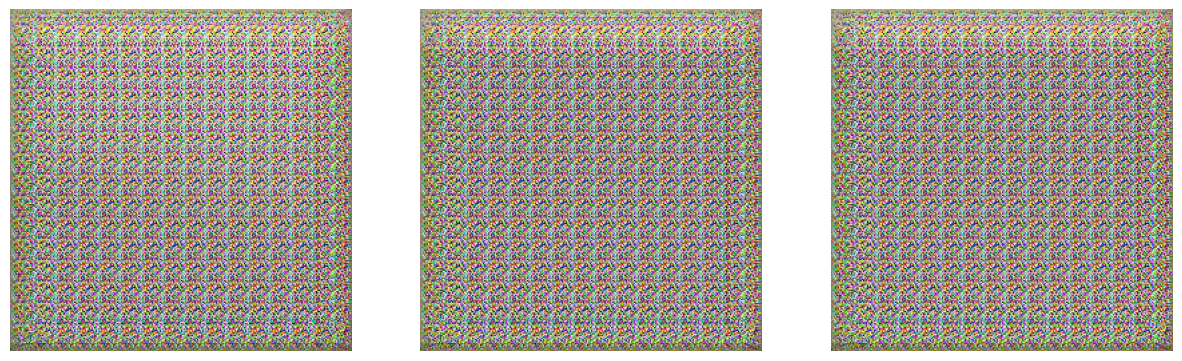

In [165]:
# Load the images from the transformed image directory
image_paths = ['images/b6398ab782.jpg', 
               'images/ea437a682c.jpg', 
               'images/9ea60e0936.jpg']  
images = [Image.open(path) for path in image_paths]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis('off')  

plt.show()

## Results and Conclusions

The uniformity in the transformed images above suggests that the current network architecture might not be complex enough to capture the variability needed for diverse outputs. This likely means the model is too simple, making it hard to effectively learn and apply the desired style transformations. To fix this, increasing the model's complexity by adding more layers or using more advanced techniques could help it produce a wider range of varied and accurate transformations.

## Reference

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

Keras Team. "Generative Examples." Keras, n.d., https://keras.io/examples/generative/. Accessed 11 Aug. 2024.